# Project CHD

## Research Questions


*   Which variables work best in predicted CHD?
*   How well do health conditions variables predict the possibility of getting CHD?
*   How well does stroke and heart rate predict the possibility of getting CHD?


## Summary

Based on data from the Framingham Heart Study which followed patients throughout their lifetime, our project explored the relationship between the measurements taken and recorded and the likelihood of developing coronary heart disease (CHD). We investigated three questions we wanted to try and answer through our analysis: which variables work best in predicted CHD, how well do health conditions variables predict the possibility of getting CHD, and how well does stroke prevalency and heart rate predict the possibility of getting CHD. Our first research question aims to investigate all of the data within the data set. Our latter two research questions aim to compare the predictive power of general health conditions with heart specific health conditions with different modeling methods on the likelihood of developing coronary heart disease.

The data used for this study is a subset of the data available from the Framingham Heart Study run by the National Institute of Health. The data set is a longitudinal data set following a sample of patients from Framingham, MA and later expanding to the relatives and offspring of the original cohort.

To do this, we chose to use linear regression, logistic regression, and a decision tree. In creating their respective pipelines, we used the same transformer, ensuring we processed the data used for each. Numeric variables were scaled using a StandardScaler and missing values were handled with a SimpleImputer using the median of the values. Moreover, categorical variables were transformed using a OneHotEncoder. A ColumnTransformer was then used to combine the two variable type pipelines. With each pipeline, we fit the models to the transformed training data and tested it against our test set producing an R-squared value.

Before we trained the data, we cleaned it slightly be removing some missing values and dropping the column education which we saw did not correlate strongly with the label.

What we discovered is that using all the variables except education with logistic regression produced the highest R-squared value, examining just health conditions without knowledge of their attributes performed worst except when using the DecisionTree, and that information on stroke and heart rate alone predicts CHD nearly as well if not better when using a Decision Tree. The highest R-squared value we recorded was 0.85849 using Logistic Regression on the whole data after it was cleaned and the lowest was 0.003861 when using Linear Regression on the subset of the data used to investigate just stroke and heart rate info. It should be noted that while we are trying are looking to create a model that successfully classifies data, not create a linear regression, we included it to see well how it could be modeled.


## Data

The data provided from the Framingham Heart Study includes 16 unique variables. What we are investigating is the variable TenYearCHD or The 10 year risk of coronary heart disease(CHD). This will be our label for our model and what will be what we ultimately test against to view our accuracy and R-squared. The rest of the variables provided are sex, education, currentSmoker, BPMeds, prevalentStroke, prevalentHyp, diabetes, age, cigsPerDay, totChol, sysBP, diaBP, BMI, heartRate, and glucose. The first seven are categorical variables classified either as a 0 or 1 (the patient has or hasn't, is or isn't, etc.). For education, however, it contained four categories 1-4 of increasing levels of education. Many of the problems we might have with this data will be handled when we create our pipeline and transformer but for now we can do some exploratory analysis of the raw data:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree

We first read the data from the CSVs and seperate by the label (TenYearCHD or The 10 year risk of coronary heart disease(CHD)), categorical variables, and numeric variables.

In [ ]:
test_data, train_data = pd.read_csv('fhs_test.csv'), pd.read_csv('fhs_train.csv')

y = 'TenYearCHD'
cat_vars = ['sex', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
num_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

Before we do any processing, we wanted to get a brief overview of the data and see if it needs to be manipulated or cleaned in anyway.


In [ ]:
print("Summary statistics: \n")
print(train_data.describe(), "\n")

print("Missing values: \n")
print(train_data.isnull().sum(), "\n")

print("Distinct values: \n")
for column in cat_vars:
    print(f"{column}: {train_data[column].unique()}")

print("Data types: \n")
print(train_data.dtypes, "\n")

print(f"TenYearCHD: {train_data['TenYearCHD'].unique()}")

Summary statistics: 

        Unnamed: 0          sex          age    education  currentSmoker  \
count  3180.000000  3180.000000  3180.000000  3095.000000    3180.000000   
mean   2129.740881     0.433019    49.633962     1.957027       0.490881   
std    1231.779357     0.495571     8.557596     1.011135       0.499995   
min       1.000000     0.000000    32.000000     1.000000       0.000000   
25%    1062.750000     0.000000    42.000000     1.000000       0.000000   
50%    2137.500000     0.000000    49.000000     2.000000       0.000000   
75%    3209.250000     1.000000    56.000000     3.000000       1.000000   
max    4240.000000     1.000000    70.000000     4.000000       1.000000   

        cigsPerDay       BPMeds  prevalentStroke  prevalentHyp     diabetes  \
count  3156.000000  3143.000000      3180.000000   3180.000000  3180.000000   
mean      8.970532     0.029590         0.006604      0.321069     0.026101   
std      12.013704     0.169479         0.081008      0.

We wanted some visualization as well so we created a heatmap of the correlation between variables.

<Axes: >

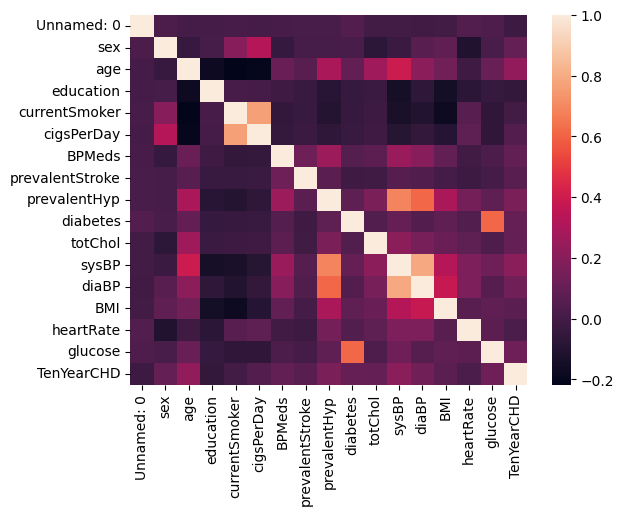

In [ ]:
train_data_corr = train_data.corr()
sns.heatmap(train_data_corr)

We notice a few things by doing this. Firstly, what was presumably a column for IDing the patients is still included in the data ("Unnamed: 0"). This will have to be dropped. In addition, from the heat map we can see that while nothing correlates too strongly with the label (looking at the bottom row), education actually has the worst correlation near 0. We'll drop this as well.





In [ ]:
train_data = train_data.drop(['Unnamed: 0', 'education'], axis=1)
test_data = test_data.drop(['Unnamed: 0', 'education'], axis=1)
cat_vars = ['sex', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

Moreover, the variables cigsPerDay, BPMeds, totChol, BMI, and glucose all have missing values. For the numeric variables, we'll handle this within our pipeline by using an imputer to calculate some value to replace the missing values with. This is a better option than dropping the rows with missing data since it means we'll still be able to use it to train. For the categorical variables with missing variables, there was only BPMeds after we dropped education. The categories for this variable was 0 and 1. To fill the NAs we replaced them with 0s since BPMeds represented a boolean, you either did take medication or you didn't and since the majority didn't (had 0), this was a suitable replacement for the missing values as well.

Additionally, for the categorial variables, we noticed that they are floats, not strings. This shouldn't be a problem, however, as we plan to use a OneHotEncoder anyways to transform the categorical data which should seperate the different distinct values regardless. This also solves our problem with missing values for them as well since NAs will just be represented as their own column in the resulting matrix.

Apart from these small observations, the numeric data will be transformed in the pipeline, as we said, and there were no other noticeable problems with the categorical data so there wasn't any more cleaning we chose to do.

In [ ]:
train_data[['BPMeds']] = train_data[['BPMeds']].fillna(0)
test_data[['BPMeds']] = test_data[['BPMeds']].fillna(0)

## Results

### Model Pipeline

Here we are defining a function that given our categorical and numeric variables we select, creates pipelines for a LinearRegressor, Logistic Regressor, and DecisionTreeClassifier.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

def pipe(cat_vars, num_vars):

    #set up variable preprocessing:
    X_vars = cat_vars + num_vars
    cat_pipeline = Pipeline(steps = [('ohc', OneHotEncoder(sparse_output=False))])
    num_pipeline = Pipeline(steps = [('maxmin', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

    #column transformer:
    preprocessor = ColumnTransformer(transformers = [('cat', cat_pipeline, cat_vars), ('num', num_pipeline, num_vars)])

    #create model specific pipelines:
    lm_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('linreg', LinearRegression(fit_intercept=False))])
    lr_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('linreg', LogisticRegression())])
    tree_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('tree', DecisionTreeClassifier(max_depth = 4))])

    #split train-test data
    X_train = train_data.loc[:, X_vars]
    X_test = test_data.loc[:, X_vars]
    y_train = train_data[y]
    y_test = test_data[y]

    #fit the models
    lm = lm_pipe.fit(X_train, y_train)
    lr = lr_pipe.fit(X_train, y_train)
    tree = tree_pipe.fit(X_train, y_train)

    #results:

    # LINEAR REGRESSION

    print('Linear Model rsq: ', lm.score(X_test, y_test) ) # R-squared
    y_hat_lm = lm.predict(X_test) # Predicted values

    print('Slope Coefficients: ', lm_pipe.named_steps['linreg'].coef_) # Regression coefficients
    print('Intercept: ', lm_pipe.named_steps['linreg'].intercept_) # Regression coefficients

    plt.scatter(x=y_hat_lm, y=y_test)
    plt.title('Linear Model: Predicted vs. Actual Values')
    plt.ylabel('TenYearCHD')
    plt.xlabel('Model Predictor')
    plt.show()

    # sns.scatterplot(x=y_test,y=y_hat_lm)
    # plt.show()

    sns.kdeplot(x=y_test - y_hat_lm).set_title('Linear Model: Residuals')
    plt.show()

    # LOGISTIC REGRESSION

    print(f'\nLogistic Regression rsq: {lr.score(X_test, y_test)}') # R-squared
    # plt.scatter(x=lr.predict_proba(X_test)[:,1], y=y_test)
    # plt.show()
    sns.regplot(x=lr.predict_proba(X_test)[:,1], y=y_test, data=train_data, logistic=True, ci=None)
    plt.title('Logistic Model: Predicted vs. Actual Values')
    plt.xlabel('Model Predictor')
    plt.show()

    # DECISION TREE

    print('\nTree rsq: ', tree.score(X_test, y_test) ) # R-squared
    y_hat_tree = tree.predict(X_test)

    tab = pd.crosstab(y_test,y_hat_tree) # Compute confusion matrix
    acc = (tab.iloc[0,0]+tab.iloc[1,1])/(tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[1,0]) # Compute Accuracy
    print('Accuracy: ', acc, '\n')
    print('Confusion Matrix:', '\n',pd.crosstab(y_test,y_hat_tree))



    plot_tree(tree_pipe.named_steps['tree'],filled=True)
    plt.show()

    # plt.scatter(x=y_hat_tree,y=y_test)
    # plt.title('Tree: Predicted vs. Actual Values')
    # plt.show()

    sns.kdeplot(x=y_test - y_hat_tree).set_title('Tree: Residuals')
    plt.show()


Linear Model rsq:  0.08794316910538147
Slope Coefficients:  [-8.47428421e+11 -8.47428421e+11 -6.08392792e+11 -6.08392792e+11
 -1.50399739e+12 -1.50399739e+12  2.06002934e+12  2.06002934e+12
 -3.40552103e+11 -3.40552103e+11  1.24034137e+12  1.24034137e+12
  5.87692261e-02  3.28979492e-02  1.20925903e-02  4.95166779e-02
 -1.74865723e-02 -1.93023682e-03  1.11389160e-03  2.63710022e-02]
Intercept:  0.0


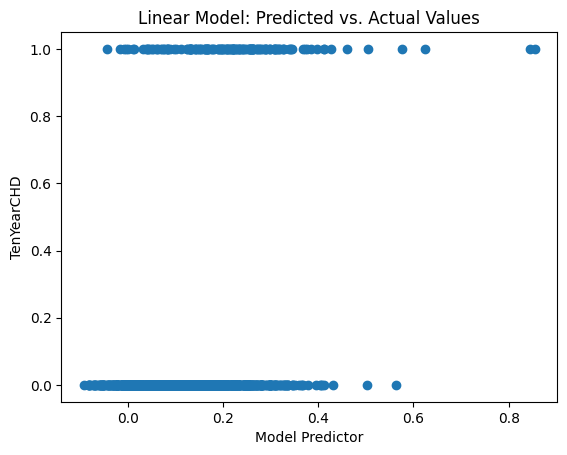

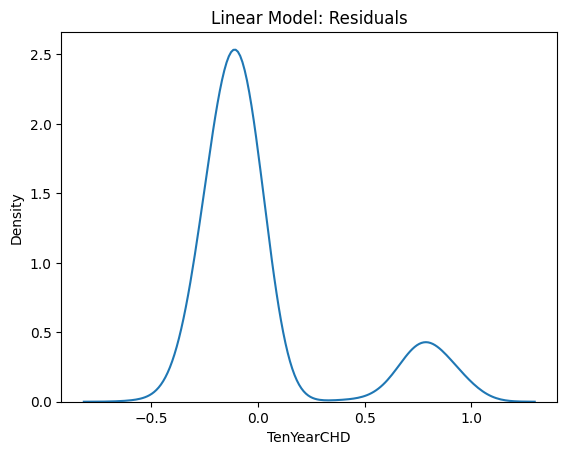


Logistic Regression rsq: 0.8603773584905661


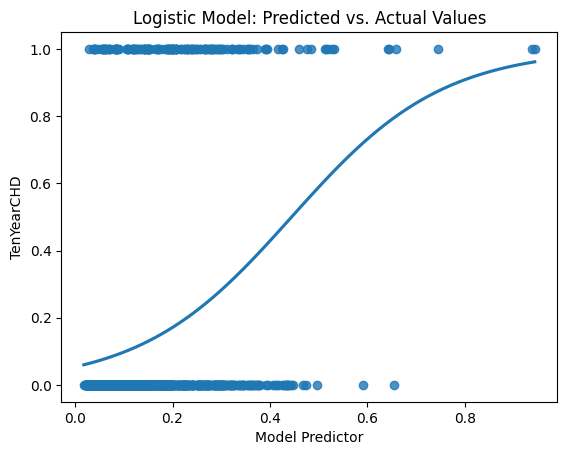


Tree rsq:  0.8443396226415094
Accuracy:  0.8443396226415094 

Confusion Matrix: 
 col_0         0   1
TenYearCHD         
0           888  15
1           150   7


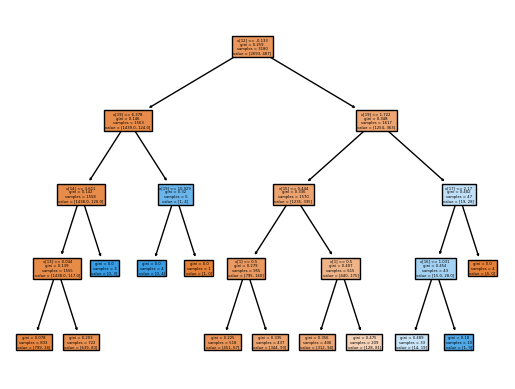

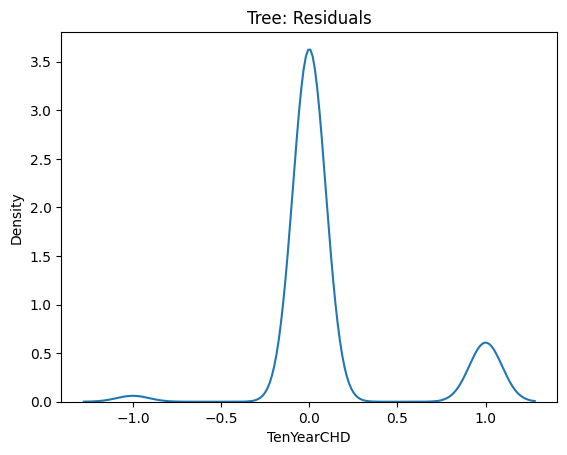

In [36]:
pipe(cat_vars, num_vars)

Because the model outcome is a binary, categorical result (as in the data can never be linear), the results from the Linear Model exist only as a reference to the Logistic Model because the values aren’t representative of how accurate the variables are for prediction.

Our first model we created was a logistic model using every single variable where we found that R^2 value to be 0.8603. This is a pretty high R^2 value where 86.03% of the variability in the data can be explained through the model. In the logistic model graph, we see a slight s-curve meaning as there are more input variables, the model is more likely to accurately predict whether a participant will get CHD within the next 10 years. Through the R^2 value and the graph, the all-variable logistic regression model seems pretty effective in predicting CHD risk.

Next, we created a decision tree using all of the variables with a max depth of four. The R^2 for the tree model is 0.8443 which, once again, is a decently high score with 84.43% of variability in the data can be explained using the decision tree. To test the accuracy of the model, we created a confusion matrix using the test data. Overall, 895 data points out of 1,060 points were accurately marked. 888 points were accurately identified as negative, 7 points were accurately identified as positive, and then 15 points were inaccurately labeled as positive, meanwhile 150 points were inaccurately labeled as negative. Another test of the decision tree classifier’s accuracy is through the density plot of the residuals. Overall, the residual plot had a bell curve centered around 0, however, there is a small peak at around +1 residual. Since it is mostly a bell curve around 0, the model appears to be mostly reliable and accurate.

We then went on to try and look at how well do health conditions variables predict the possibility of getting CHD so we reduce the variables to only those relating to health, such as whether or not the patient had stroke or hypertension as well as their biological levels of health attributes. 

Linear Model rsq:  0.06467484480883523
Slope Coefficients:  [-1.44881748e+12 -1.44881748e+12  1.44881748e+12  1.44881748e+12
  2.07970142e-02  7.44018555e-02 -2.66590118e-02  1.84726715e-03
 -6.35528564e-03  3.60488892e-02]
Intercept:  0.0


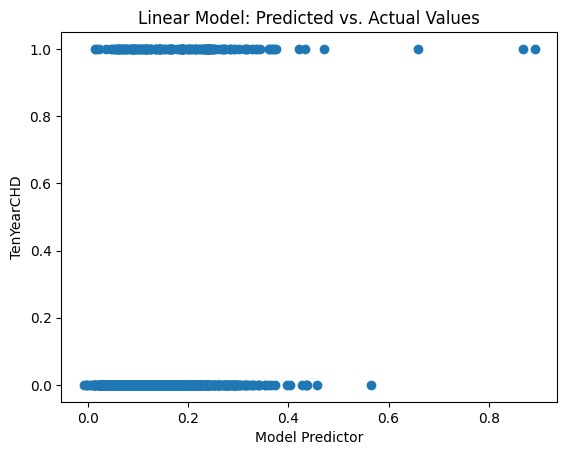

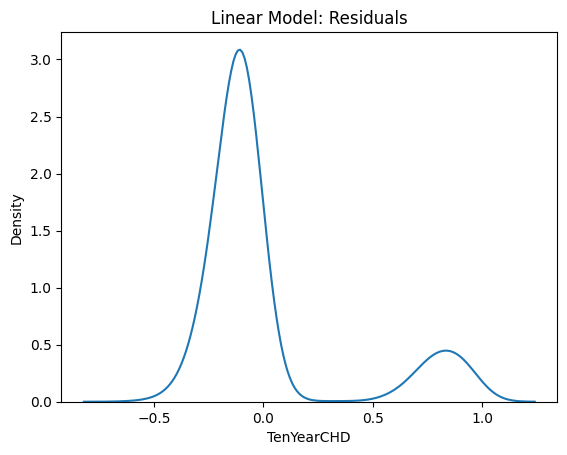


Logistic Regression rsq: 0.8518867924528302


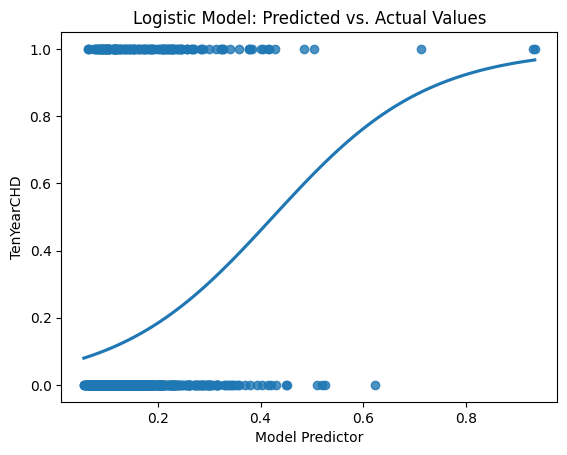


Tree rsq:  0.8462264150943396
Accuracy:  0.8462264150943396 

Confusion Matrix: 
 col_0         0   1
TenYearCHD         
0           890  13
1           150   7


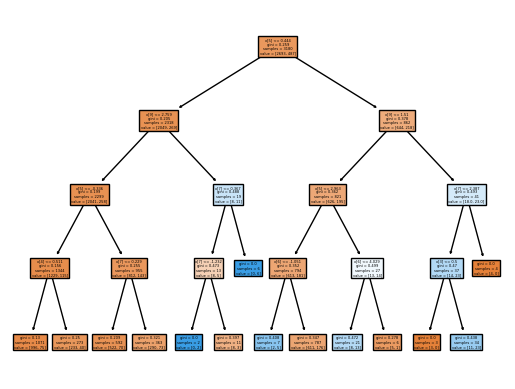

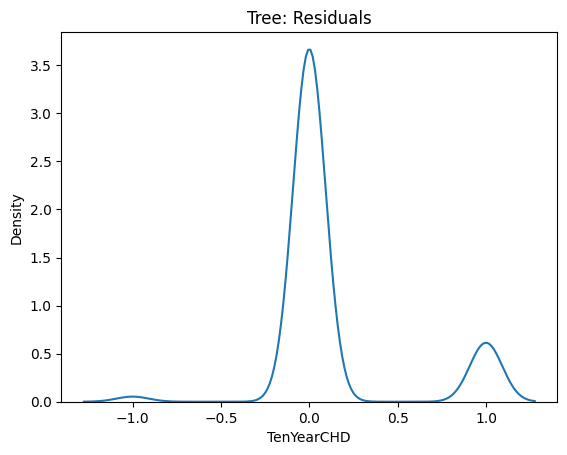

In [37]:
# cat_vars = ['sex', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
# num_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

pipe(['prevalentStroke', 'prevalentHyp'], ['totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'])



First, we created a logistic regression model with an R^2 value of 0.8519. This continues to be a decently high R^2 value where 85.19% of the variability in the data can be explained through the model, however it is slightly lower than the R^2 value of the logistic model with all variables. Through the graph, we see a very similar slight s-curve shape as we did in the previous logistic model. Again, what this means is that with more input variables, the better the model is at accurately predicting whether that participant would get CHD. Therefore, from the R^2 and the graph, the logistic model using the health conditions seems like an accurate predictor for predicting whether people will develop CHD.

Using the health condition variables, we created a decision tree classifier model. The R^2 value for the model is 0.8462 which is overall a high score and even slightly higher than the decision tree R^2 with all variables. Through the confusion matrix, we found that the model correctly identified 890 points as negative and 8 points as positive, meanwhile, the model incorrectly identified 13 points as positive when it should’ve been negative and 150 points as negative when it should’ve been positive. Overall, the values are extremely similar to the previously created decision tree model. Even when looking at the residual plot, it is very similar to the previous model since the density plot shows a mostly normal bell curve around 0 except for a small peak at +1. While the R^2 value isn’t as high as the logical regression model, the decision tree model is quite close and also proves to be an accurate predicting model.


Lastly, we examined how much does stroke prevalency and heart rate predict the possibility of getting CHD. The only variables used here were prevalentStroke and heartRate.


Linear Model rsq:  0.003861077403707891
Slope Coefficients:  [0.15129597 0.43124024 0.00891029]
Intercept:  0.0


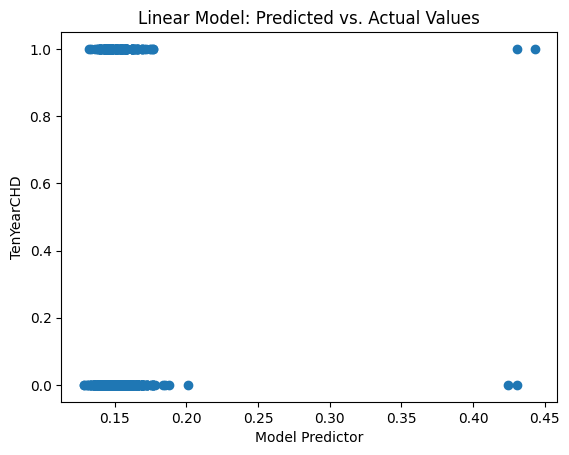

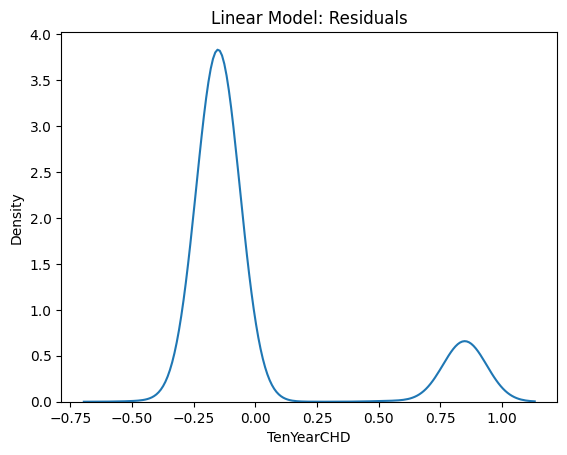


Logistic Regression rsq: 0.8518867924528302


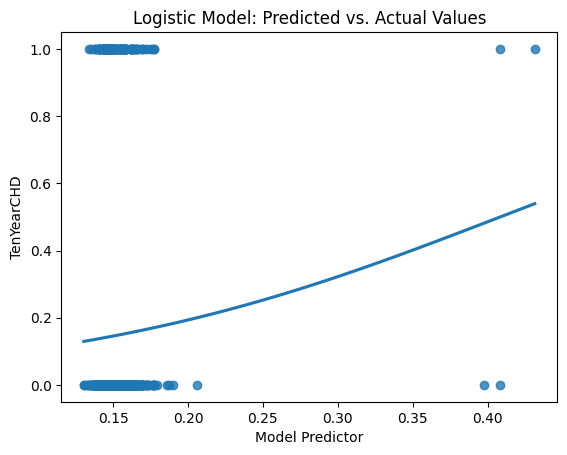


Tree rsq:  0.8528301886792453
Accuracy:  0.8528301886792453 

Confusion Matrix: 
 col_0         0  1
TenYearCHD        
0           903  0
1           156  1


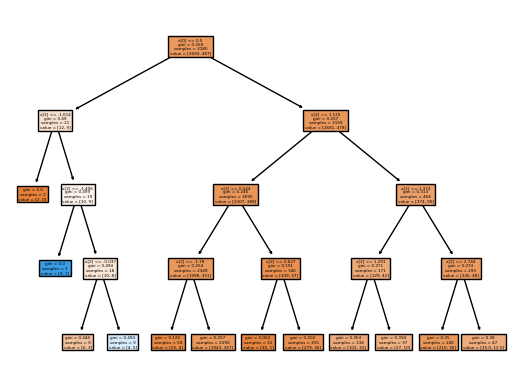

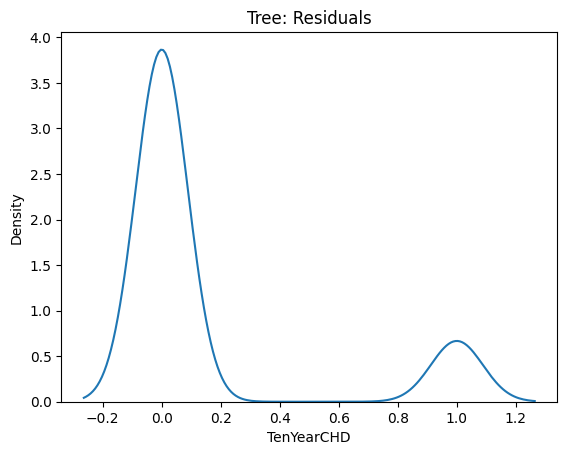

In [38]:
pipe(['prevalentStroke'], ['heartRate'])

With the logistic model, the R^2 value ended up being 0.8519 which is around the same as the previous two model’s R^2 values. Overall, it is a high R^2 indicating that 85.19% of variability shown in the data can be explained through this logistic regression model with only prevalent stroke and heart rate as variables. However, when looking at the graph marking the logistic regression, there is hardly any curve, but rather just a positive sloping line. What this means is that the relationship between the variables in this model doesn’t strongly associate with predicting CHD. As input variables are added in the model, while there is some increase in accuracy, there is not really much improvement given that the logistic regression curve ends around 0.6 at the right most end of the graph (where previous logistic model graphs would have the curve ending at 1.0). Despite the high R^2 value, the graph does not suggest that this logistic regression model with stroke and heart rate behavior is accurate.

The decision tree classifier using the two stroke and heart rate variables ended up having an R^2 value of 0.8528 which is higher than the previous decision tree model R^2 values with more variables. Using the confusion matrix, the model was able to identify 903 points correctly as negative and identify 1 point correctly as positive. Meanwhile, the model did not identify a single false positive, however, it misclassified 156 points as negative when the cases should have been positive. From the confusion matrix, we see that this model generally isn’t able to predict any case as positive. From all 1,060 data points, it only predicted that one patient would get CHD. While its prediction was right, the model resulted in a lot of false negatives. If we look at the accuracy of the model through the density plot of the residuals, we can also see that it is somewhat more bimodal than before rather than a bell curve at 0. There is a peak at 0, however, the curve is wider and spans from -0.2 to 0.2. There is also a peak at 1.0, but once again, the curve is wider than before spanning from 0.8 to 1.2. Overall, the residual plot shows that there is some sort of unusual unevenness with the predictions of the model. Despite the high R^2 value, the decision tree classifier model using only heart rate and stroke prevalence variables doesn’t seem to be accurate in predicting CHD because of the pattern displayed in the confusion matrix and the results from the residual plot.

## Conclusion

Overall we found that all of variables with the exception of education when used together in logistic regression produced the highest R-squared value. This was followed closely by modeling heart health conditions with a decision tree.

By including all of the variables, except for education, we achieved the highest R-squared value in a logistic regression. From this result we believe that this means many of the individual demogrpahic and lifestyle serve as good predictors for CHD and were able to result in a higher accuracy when included in the model. This includes factors such as sex, age, cigsPerDay, BPmeds which is further supported by our heatmap. Specifically, in a real world context, when performing a diagnosis there is a significant value in recording demographic and lifestyle details of the patient.

Interestingly, between the models using the listed medical conditions (prevalentStroke, prevalentHyp, totChol, sysBP, diaBP, BMI, heartRate, and glucose) and the models using just heart health conditions (prevalentStroke, prevalentHyp) we found that the model using only heart health conditions had a slightly better R-square value. This seems to suggest cardiovascular health conditions are just slightly better as predictors. However, when also including many other health conditions, the R-squared value was very close. In a real world context for diagnosing a patient, measuring other health factors may be useful in getting clearer analysis of a patient's physical health, but will not be more useful than just observing heart health conditions.

One major limitation with our data is that there are many more cases of a patient not having CHD over positive cases. This means our data is skewed and this skew can result in our accuracy appearing much better than it actually is. The majority of patients did not have CHD so for a model to mostly produce labels of 0 (does not have), it will by extension be right most of the time regardless of how it arrived at that conclusion. Moreover, because our models deal with diagnosing a health condition, there is much more context to this problem than our reported R-squared value.

For something like this to be used in a clinical setting, the model would have to be adjusted to handle false positives and false negatives in a more detailed manner. Arguably, with medical diagnosis, especially with a more serious condition such as CHD, false negatives are especially dangerous. It would not be ideal to overdiagnose patients, but missing a diagnosis could be especially problematic. Since the dataset consists of more patients without CHD, we would be worried about details around false negatives.